First model I have run is using Elo Ratings that I'm sure we are all familiar with. A lot if this is following [this](https://www.zeileis.org/papers/Leitner+Zeileis+Hornik-2010.pdf) paper on the 2010 World Cup. I have taken the Elo ratings from [eloratings.net](https://www.eloratings.net/), which goes all the way back to the first international in 1872 (a 0-0 draw between Scotland and England). It calculates rating based on the formula 

$$ R_n = R_o + K (W-W_e), W_e = \frac{1}{10^{(-d/400)}+1} $$

With $K$ a weighting constant depending on the tournament being played, $W$ the result of the game (0, 0.5 or 1), $W_e$ is the expected result using $d$, the difference in ratings (plus 100 for home advantage). Using pairwise comparison $ Prob(A~beats~B) = \frac{ability_a}{ability_a+ability_b} $ to give:

$$ Prob(A~beats~B) =  \frac{1}{10^{-(Elo_a -Elo_b/400)}+1}$$


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter

In [90]:
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
plt.rcParams["font.weight"] = "light"
plt.style.use('fivethirtyeight')

In [2]:
teams = ['Brazil','France','Argentina','England',
'Spain','Germany','Netherlands','Portugal',
'Belgium','Denmark','Croatia','Uruguay',
'Senegal','Serbia','Switzerland',
'Mexico','Poland','USA','Ecuador',
'Wales','Morocco','South Korea',
'Japan','Cameroon','Ghana','Qatar',
'Canada','Australia','Iran','Tunisia',
'Saudi Arabia','Costa Rica']

In [3]:
elo = [2169,2005,2141,1920,2045,1960,2040,2004,2025,1971,1922,1936,1687, 1893, 1929, 1813, 1809,1798,1840, 1790, 1754, 1783, 1798, 1613, 1541, 1650, 1770, 1719, 1817, 1687, 1632, 1737]

In [4]:
def pairwise_comparison_elo(A,B):
    probA = 1/((10**(-(A-B)/400))+1)
    return probA

/opt/conda/envs/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if sys.path[0] == "":


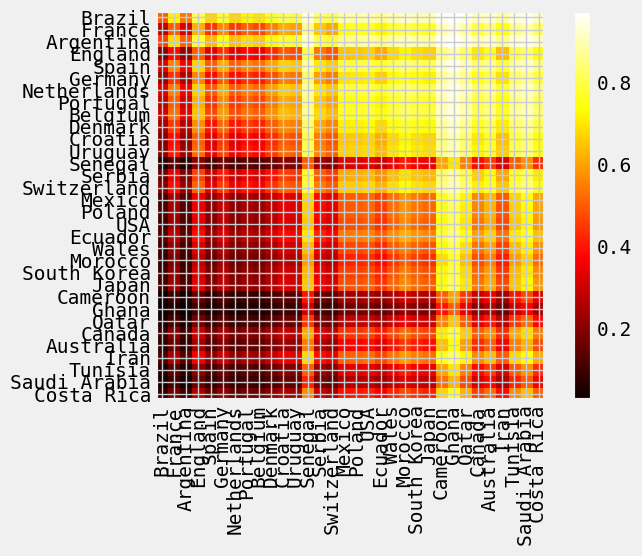

In [131]:
list1=[]
for i in range(32):
    list2=[]
    for j in range(32):
        i_beats_j = pairwise_comparison_elo(elo[i], elo[j])
        list2.append(i_beats_j)
    list1.append(list2)
fig, ax = plt.subplots()
im = ax.imshow(np.array(list1), cmap='hot')
ax.set_xticks(np.arange(len(teams)), labels=teams,rotation=90);
ax.set_yticks(np.arange(len(teams)), labels=teams);
ax.figure.colorbar(im, ax=ax)

Now we can simulate a group game using the win probabilities and a random sample from a uniform distribution. We can then award 3 points to the winner. Since this does not give us goal difference or even draw probabilities, I have made some slight 'changes to the rules of group stages. Any ties will go straight to head to head record, in the case of a three-way tie the two teams with the highest Elo rankings will progress from the group stage.

In [11]:
zip_iterator = zip(teams, elo)
elo_dictionary = dict(zip_iterator)

In [12]:
def simulate_group_game(teamA,teamB, teamA_points, teamB_points, winA=0):
    teamA_win_prob = pairwise_comparison_elo(elo_dictionary[teamA], elo_dictionary[teamB])
    if random.uniform(0, 1) <= teamA_win_prob:
        teamA_points += 3
        winA=1
    else:
        teamB_points += 3
        winA=-1
    return(teamA_points, teamB_points, winA)

Putting many of these together along with our group stage logic allows us to simulate a group

In [13]:
def simulate_group(group, pts):
    for i in range(4):
        for j in range(i+1,4):
            (x,y,winA) = simulate_group_game(group[i],group[j], pts[i], pts[j])
            win_array[i][j]=winA
            win_array[j][i]=-winA
            pts[i] = x
            pts[j] = y

In [61]:
# This is a bit of a mess
def qualifiers(group, group_pts, group_winners, group_runners_up, grp_elo): 
    grp_sorted_points = sorted(group_pts, reverse = True)
    if grp_sorted_points[0] > grp_sorted_points[1]: #unique winner
        grp_winner_idx =np.argmax(group_pts)
        grp_winner = group[grp_winner_idx]
        del grp_elo[grp_winner]
        grp_runner_up = max(grp_elo, key=grp_elo.get)
    elif grp_sorted_points[1] > grp_sorted_points[2]:#two-way-tie (head to head)
        idx1 = np.argmax(group_pts)
        group_pts_copy = group_pts.copy()
        group_pts_copy[idx1] = 0
        idx2 = np.argmax(group_pts_copy)
        if win_array[idx1, idx2] == 1:
            grp_winner = group[idx1]
            grp_runner_up = group[idx2]
        else:
            grp_winner = group[idx2]
            grp_runner_up = group[idx1]
    else:
        grp_winner = max(grp_elo, key=grp_elo.get)
        del grp_elo[grp_winner]
        grp_runner_up = max(grp_elo, key=grp_elo.get)
    group_winners.append(grp_winner)
    group_runners_up.append(grp_runner_up)

In [130]:
## Example
groupA = ['Qatar','Ecuador','Senegal','Netherlands']
groupApts =[0,0,0,0]
win_array = np.zeros((4,4))
grp_elo = {k: v for k, v in elo_dictionary.items() if k in groupA}
group_winners=[]
group_runners_up =[]

simulate_group(groupA,groupApts)
qualifiers(groupA, groupApts, group_winners, group_runners_up, grp_elo)
print(groupA)
print(groupApts)
print(win_array)
print(group_winners)
print(group_runners_up)

['Qatar', 'Ecuador', 'Senegal', 'Netherlands']
[3, 3, 3, 9]
[[ 0. -1.  1. -1.]
 [ 1.  0. -1. -1.]
 [-1.  1.  0. -1.]
 [ 1.  1.  1.  0.]]
['Netherlands']
['Ecuador']


We can now simulate each group and incorporate the knock out stage. Run this many times to see how often each team wins the tournament!

In [65]:
####### Allocate all the groups
groupA = ['Qatar','Ecuador','Senegal','Netherlands']
groupB = ['England','Iran','USA','Wales']
groupC = ['Argentina','Saudi Arabia','Mexico','Poland']
groupD = ['France','Australia','Denmark','Tunisia']
groupE = ['Spain','Costa Rica','Germany','Japan']
groupF = ['Belgium','Canada','Morocco','Croatia']
groupG = ['Brazil','Serbia','Switzerland','Cameroon']
groupH = ['Portugal','Ghana','Uruguay','South Korea']

In [69]:
final_winners = []
for runs in range(1000000):
    grps = [groupA,groupB,groupC,groupD,groupE,groupF,groupG,groupH]
    group_winners = []
    group_runners_up = []
    for i, grp in enumerate(grps):
        group1 = grp
        group1pts =[0,0,0,0]
        win_array = np.zeros((4,4))
        grp_elo = {k: v for k, v in elo_dictionary.items() if k in group1}

        simulate_group(group1,group1pts)

        ## who qualifies from group
        qualifiers(group1, group1pts, group_winners, group_runners_up, grp_elo)
        
    ####### simulate knockouts (also a bit of a mess to get the structure right) Double check it
    game1_winner = group_winners[0] if simulate_group_game(group_winners[0], group_runners_up[1],0,0)[2]==1 else group_runners_up[1]
    game2_winner = group_winners[1] if simulate_group_game(group_winners[1], group_runners_up[0],0,0)[2]==1 else group_runners_up[0]
    game3_winner = group_winners[2] if simulate_group_game(group_winners[2], group_runners_up[3],0,0)[2]==1 else group_runners_up[3]
    game4_winner = group_winners[3] if simulate_group_game(group_winners[3], group_runners_up[2],0,0)[2]==1 else group_runners_up[2]
    game5_winner = group_winners[4] if simulate_group_game(group_winners[4], group_runners_up[5],0,0)[2]==1 else group_runners_up[5]
    game6_winner = group_winners[5] if simulate_group_game(group_winners[5], group_runners_up[4],0,0)[2]==1 else group_runners_up[4]
    game7_winner = group_winners[6] if simulate_group_game(group_winners[6], group_runners_up[7],0,0)[2]==1 else group_runners_up[7]
    game8_winner = group_winners[7] if simulate_group_game(group_winners[7], group_runners_up[6],0,0)[2]==1 else group_runners_up[6]
    ######## sim quarter-finals
    q1_winner = game1_winner if simulate_group_game(game1_winner, game3_winner,0,0)[2]==1 else game3_winner
    q2_winner = game2_winner if simulate_group_game(game2_winner, game4_winner,0,0)[2]==1 else game4_winner
    q3_winner = game5_winner if simulate_group_game(game5_winner, game7_winner,0,0)[2]==1 else game7_winner
    q4_winner = game6_winner if simulate_group_game(game6_winner, game8_winner,0,0)[2]==1 else game8_winner
    ###### sim semi-finals
    s1_winner = q1_winner if simulate_group_game(q1_winner, q3_winner,0,0)[2]==1 else q3_winner
    s2_winner = q2_winner if simulate_group_game(q2_winner, q4_winner,0,0)[2]==1 else q4_winner
    ###### sim final
    winner = s1_winner if simulate_group_game(s1_winner, s2_winner,0,0)[2]==1 else s2_winner
    final_winners.append(winner)

In [76]:
winners_count = Counter(final_winners)
winners_count.most_common()

[('Brazil', 268779),
 ('Argentina', 215743),
 ('Netherlands', 88537),
 ('Spain', 79487),
 ('France', 66953),
 ('Belgium', 65653),
 ('Portugal', 51664),
 ('Denmark', 38880),
 ('Germany', 30411),
 ('Switzerland', 21866),
 ('England', 19754),
 ('Uruguay', 17889),
 ('Croatia', 14624),
 ('Ecuador', 8008),
 ('Mexico', 4448),
 ('Iran', 2704),
 ('Serbia', 1490),
 ('USA', 872),
 ('Wales', 760),
 ('Poland', 406),
 ('Japan', 296),
 ('South Korea', 243),
 ('Canada', 170),
 ('Morocco', 118),
 ('Australia', 84),
 ('Costa Rica', 71),
 ('Senegal', 35),
 ('Tunisia', 33),
 ('Qatar', 18),
 ('Cameroon', 2),
 ('Saudi Arabia', 2)]

In [100]:
bf_odds = [5.8,7.6,8.6,9.2,10,12,15.5,17,18.5,38,55,65,90,120,160,230,230,260,310,320,360,360,420,420,440,540,630,700,810,860,1000,1000]
bf_probs = [1/n for n in bf_odds]
scaled_bf_prob = [p/sum(bf_probs) for p in bf_probs]

In [84]:
sorted_elo = {k: v for k, v in sorted(elo_dictionary.items(), key=lambda item: item[1], reverse=True)}

In [97]:
sorted_wins = [winners_count[i]/10000 for i in sorted_elo.keys()]

Text(0.1, 0.94, 'FIFA 2022 Qatar World Cup\nELO Ranking vs. Simulated Probability')

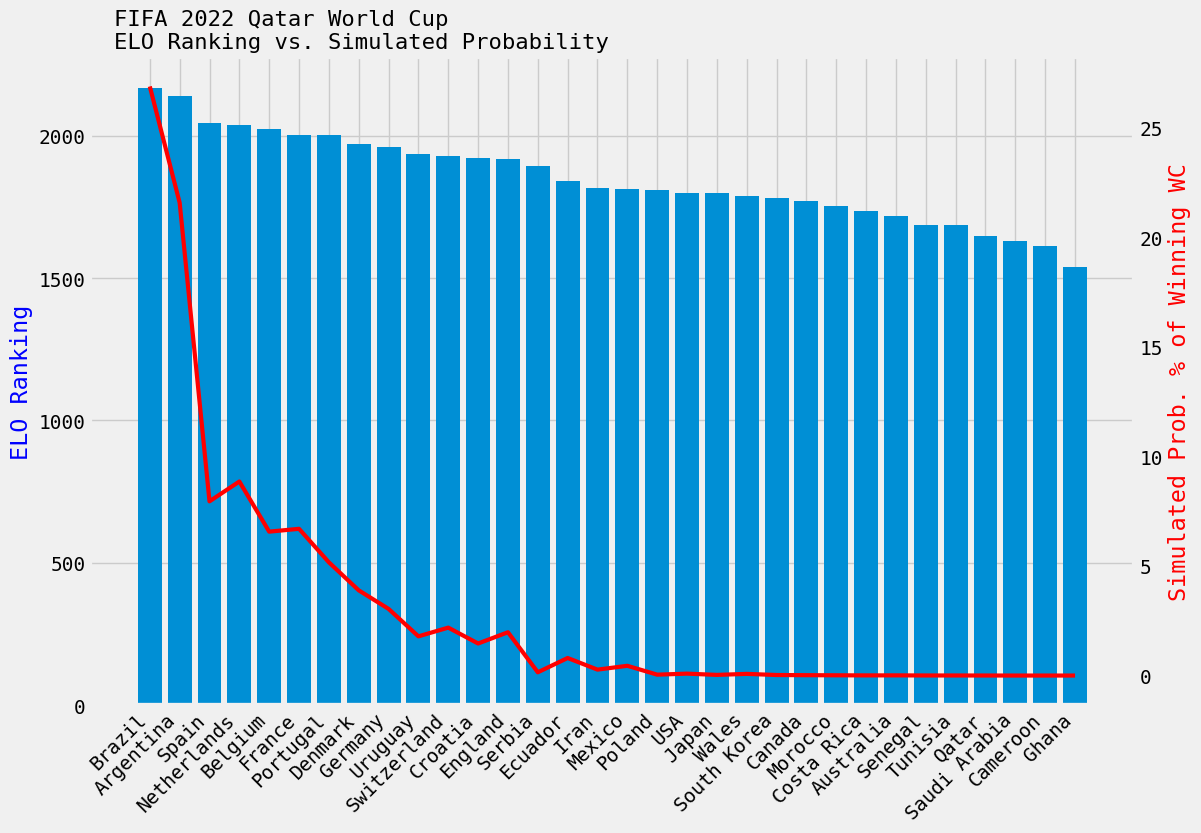

In [148]:
fig,ax = plt.subplots(figsize=(12,8))
ax.bar(range(32), sorted_elo.values())
ax.set_xticks(range(32), sorted_elo.keys(), rotation = 45, ha='right');
ax.set_ylabel('ELO Ranking', color='blue')
ax2 = ax.twinx()
ax2.grid(None)
ax2.plot(range(32), sorted_wins, color='red',lw=3)
ax2.set_ylabel('Simulated Prob. % of Winning WC', color='red')
fig.suptitle('FIFA 2022 Qatar World Cup\nELO Ranking vs. Simulated Probability', x=0.1, y=0.94, ha='left',size=16)

We can see that the general trend holds that higher the Elo rating the higher the Elo model rates a teams changes of winning, which is to be expected!! But there are a few discrtepancies that show how the tournament structure can affect this, for example the Netherlands look to have an easier route to the trophy. Now lets compare that to what the bookies think. Here I am just using prices from the bf outright market, but in future we can be a bit more clever and combine bookie prices and weight by stake (I recognise this from somewhere...). I have alose scaled the bf probabilities so they sume to 1 in an effort to remove the overround.

In [150]:
sorted_wins_by_team = [winners_count[i]/10000 for i in teams]
df = pd.DataFrame(list(zip(teams, sorted_wins_by_team, [x*100 for x in scaled_bf_prob])), columns = ['teams', 'elo', 'bkie'])
df.head(10)

,teams,elo,bkie
0,Brazil,26.8779,16.969543
1,France,6.6953,12.950441
2,Argentina,21.5743,11.444576
3,England,1.9754,10.698190
4,Spain,7.9487,9.842335
5,Germany,3.0411,8.201946
6,Netherlands,8.8537,6.349894
7,Portugal,5.1664,5.789609
8,Belgium,6.5653,5.320181
9,Denmark,3.8880,2.590088


Text(17, 7, 'Model believes that\nthese teams have a\nhigher probability\nof winning')

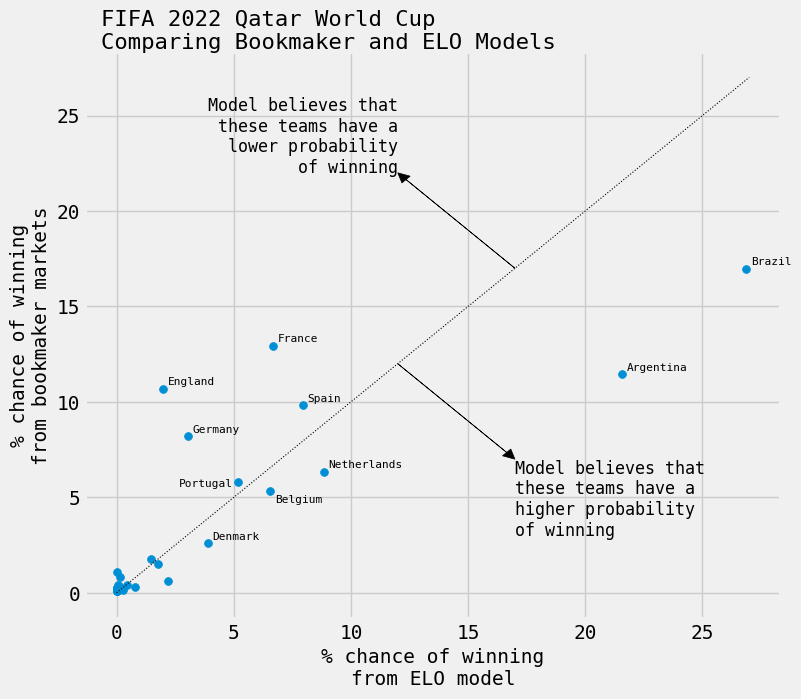

In [196]:
fig,ax = plt.subplots(figsize=(8,7))
ax.scatter(df['elo'], df['bkie'],s = 32)
ax.set_xlabel('% chance of winning\nfrom ELO model', size=14)
ax.set_ylabel('% chance of winning\nfrom bookmaker markets', size=14)
ax.plot([0,27],[0,27],lw=0.8, ls=':', color='black')
ax.arrow(17, 17, -5, 5, head_width=0.5, head_length=0.5, fc='k', 
         ec='k', length_includes_head=True)
ax.arrow(12, 12, 5, -5, head_width=0.5, head_length=0.5, fc='k', 
         ec='k', length_includes_head=True)
for i, label in enumerate(teams[0:7]):
    plt.annotate(label, (df['elo'][i]+0.2, df['bkie'][i]+0.2), size=8)
plt.annotate('Portugal', (df['elo'][7]-0.2, df['bkie'][7]-0.2), size=8, ha='right')
plt.annotate('Belgium', (df['elo'][8]+0.2, df['bkie'][8]-0.6), size=8)
plt.annotate('Denmark', (df['elo'][9]+0.2, df['bkie'][9]+0.2), size=8)
fig.suptitle('FIFA 2022 Qatar World Cup\nComparing Bookmaker and ELO Models', x=0.1, y=0.94, ha='left',size=16)
ax.text(12, 22, 'Model believes that\nthese teams have a\nlower probability\nof winning', size=12, ha='right')
ax.text(17, 7, 'Model believes that\nthese teams have a\nhigher probability\nof winning', size=12, ha='left', va='top')

In [161]:
df

,teams,elo,bkie
0,Brazil,26.8779,16.969543
1,France,6.6953,12.950441
2,Argentina,21.5743,11.444576
3,England,1.9754,10.698190
4,Spain,7.9487,9.842335
5,Germany,3.0411,8.201946
6,Netherlands,8.8537,6.349894
7,Portugal,5.1664,5.789609
8,Belgium,6.5653,5.320181
9,Denmark,3.8880,2.590088


In [172]:
df['bk_odds'] = 100/df['bkie']
df['elo_odds'] = 100/df['elo']
df['odd_ratio'] = df['bk_odds']/df['elo_odds']

In [173]:
df.head()

,teams,elo,bkie,bk_odds,elo_odds,odd_ratio
0,Brazil,26.8779,16.969543,5.892911,3.720529,1.583891
1,France,6.6953,12.950441,7.721745,14.935851,0.516994
2,Argentina,21.5743,11.444576,8.737764,4.635145,1.885111
3,England,1.9754,10.698190,9.347375,50.622659,0.184648
4,Spain,7.9487,9.842335,10.160191,12.580674,0.807603


In [199]:
tp = df.sort_values('odd_ratio', ascending=False)
tp

,teams,elo,bkie,bk_odds,elo_odds,odd_ratio
14,Switzerland,2.1866,0.615146,162.563049,4.573310e+01,3.554604
18,Ecuador,0.8008,0.317495,314.965908,1.248751e+02,2.522247
28,Iran,0.2704,0.121510,822.975438,3.698225e+02,2.225326
2,Argentina,21.5743,11.444576,8.737764,4.635145e+00,1.885111
0,Brazil,26.8779,16.969543,5.892911,3.720529e+00,1.583891
9,Denmark,3.8880,2.590088,38.608724,2.572016e+01,1.501107
6,Netherlands,8.8537,6.349894,15.748295,1.129471e+01,1.394307
8,Belgium,6.5653,5.320181,18.796353,1.523160e+01,1.234037
11,Uruguay,1.7889,1.514205,66.041239,5.590027e+01,1.181412
15,Mexico,0.4448,0.427928,233.684384,2.248201e+02,1.039428


In [194]:
plt.rcParams['text.usetex'] = False

Text(20, 3.33, 'Prob(team wins from bookie odds)')

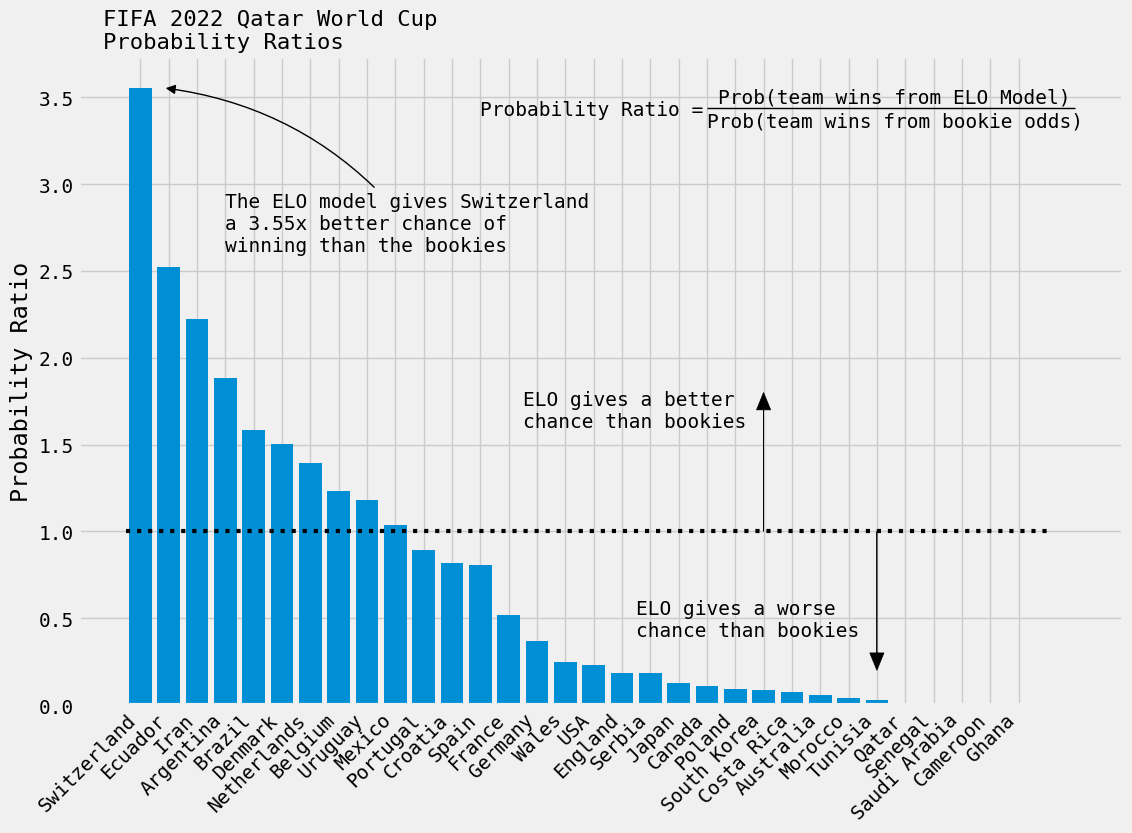

In [247]:
fig,ax = plt.subplots(figsize=(12,8))
ax.bar(range(32), tp['odd_ratio'])
ax.set_xticks(range(32), tp['teams'], rotation = 45, ha='right');
ax.set_ylabel('Probability Ratio')
ax.hlines(1,-0.5,32, color='black', ls=':', lw=3)
fig.suptitle('FIFA 2022 Qatar World Cup\nProbability Ratios', x=0.1, y=0.94, ha='left',size=16)
ax.arrow(22, 1, 0, 0.8, head_width=0.5, head_length=0.1, fc='k', 
         ec='k', length_includes_head=True)
ax.text(13.5,1.6,'ELO gives a better\nchance than bookies')
ax.arrow(26, 1, 0, -0.8, head_width=0.5, head_length=0.1, fc='k', 
         ec='k', length_includes_head=True)
ax.text(17.5,0.4,'ELO gives a worse\nchance than bookies')
ax.annotate('The ELO model gives Switzerland\na 3.55x better chance of\nwinning than the bookies',ha = 'left', va='top', 
      xy=(0.8, 3.555), xycoords='data', color='black',
      xytext=(3, 2.955) ,textcoords='data',
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle="arc3,rad=0.2",
                      fc="black", ec="black", lw=1))
ax.text(12,3.4,'Probability Ratio = ')
ax.text(20.4,3.47,'Prob(team wins from ELO Model)')
ax.hlines(3.44,20,33, color='black', lw=1)
ax.text(20,3.33,'Prob(team wins from bookie odds)')